<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# Practical 3: Text Classification

In the previous practicals we created some IMDB movie review data for sentiment analysis and explored several text pre-processing and representation methods. By now you should have pre-processed the reviews you scraped from IMDB and also the full 50,000 review dataset. So, now we are ready to train a model to classify the sentiment of our movie reviews! We will explore several unsupervised and supervised approaches, using an existing movie review dataset for training and keep ours as an additional test set.

In the first part of this practical we will explore two supervised classification algorithms, Naive Bayes and an Artificial Neural Network (ANN).

In the second part of this practical we will look at several unsupervised algorithms K-means clustering and Semantic Analysis using word embeddings.

The objectives of this practical are:

1. Apply a complete NLP workflow for text classification

2. Understand the probabilistic Naive Bayes classifier and consider different aspects of applying an ANN to text data

3. Consider appropriate representations for unsupervised text classification, including clustering and semantic analysis with word embeddings

# 1 Supervised Text Classification

## 1.0 Import libraries

1. [Tensorflow](https://www.tensorflow.org/) - is a powerful Python library for machine learning.

2. [Keras](https://keras.io/) - is a simple API for building machine learning models and is built into Tensorflow 2.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data/imdb)
data_dir = os.path.join(path, 'data', 'imdb')

# Set the directory to the shared dataset folder (should be in shared/datasets/imdb)
dataset_dir = os.path.join(path, '..', 'shared', 'datasets', 'imdb')

# Load the Spacy language model ('en_core_web_md' should be in shared/models/spacy)
nlp = spacy.load(os.path.join(path, '..', 'shared', 'models', 'spacy'))

## 1.1 Load and pre-process data

1. First load the full IMDB dataset and our smaller reviews set.

2. Then we need to convert the 'positive' and 'negative' class labels to numerical values, 1 for positive and 0 for negative. Using the pandas `get_dummies` function creates two binary valued columns and then the `drop_first` parameter collapses these into a single column.

3. The next cell plots the distribution of review sentiment for the dataset and our reviews. As you can, see the classes are perfectly balanced within the dataset, but are they in your data?

In [2]:
# Load the imdb dataset
imdb_dataset = pd.read_csv(os.path.join(dataset_dir, 'imdb_dataset.csv'))

# Load your imdb reviews
imdb_reviews = pd.read_csv(os.path.join(data_dir, 'imdb_reviews.csv'))

# # Convert the sentiment to a binary value
imdb_dataset['sentiment'] = pd.get_dummies(imdb_dataset['sentiment'], drop_first=True)
imdb_reviews['sentiment'] = pd.get_dummies(imdb_reviews['sentiment'], drop_first=True)

imdb_reviews

,review,sentiment
0,there is a new nuclear arms race underway supe...,False
1,superman iv the quest for peace is a good movi...,False
2,very odd and very short color film that tries ...,True
3,the acting costumes and dialog for monsters cr...,True
4,while the batman franchise has been much malig...,True
...,...,...
95,i have always wondered if director jack arnold...,True
96,following up one of the greatest horror films ...,True
97,inside this terrible film is an excellent film...,False
98,10 10 better than citizen kane casablanca and ...,True


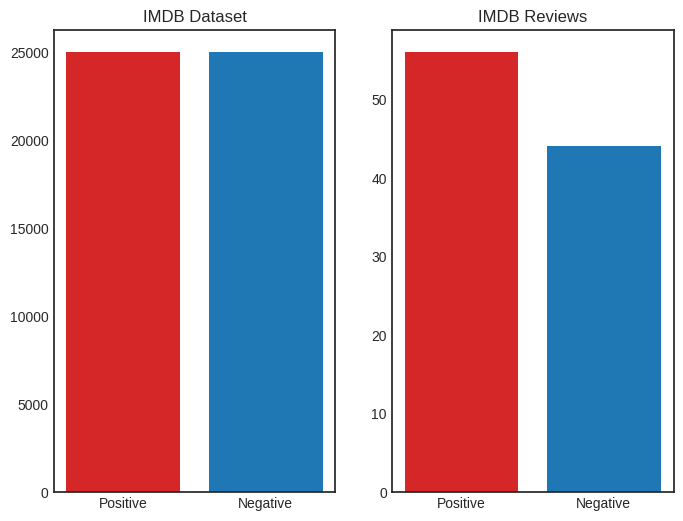

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].set_title('IMDB Dataset')
ax[0].bar(['Positive', 'Negative'], height=imdb_dataset['sentiment'].value_counts(), color=['tab:red', 'tab:blue'])
ax[1].set_title('IMDB Reviews')
ax[1].bar(['Positive', 'Negative'], height=imdb_reviews['sentiment'].value_counts(), color=['tab:red', 'tab:blue'])
plt.show()

### Process and vectorise the text

1. We will use sklearn's `CountVectorizer()` to tokenise the text and vectorise each review into a BOW. We will also remove english stop words

2. Once the text is vectorised, split into training and validation sets. Use your IMDB reviews as the test set.

In [4]:
# Set the vocab size
vocab_size = 5000

# Create a CountVectorizer
bow_vectoriser = CountVectorizer(max_features=vocab_size, stop_words='english')

# Vectorise the text
X = bow_vectoriser.fit_transform(imdb_dataset['review']).toarray()
print(f'Shape of X: {X.shape}')
print(X[:5, :])

# Get the class labels
y = imdb_dataset['sentiment'].values
print(f'Shape of y: {y.shape}')
print(y[:5])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorise the text for the test set
X_test = bow_vectoriser.transform(imdb_reviews['review']).toarray()

# Get the class labels
y_test = imdb_reviews['sentiment'].values

Shape of X: (50000, 5000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 2 0 0]
 [0 0 0 ... 0 0 0]]
Shape of y: (50000,)
[ True  True  True False  True]


## 1.2 Naive Bayes

Naïve Bayes is a generative classification algorithm which finds the probability of an event based on prior knowledge/examples of similar events. It is naïve, because it assumes that each feature is independent (do not effect each other) so we can calculate probabilities independently.

The class defined below implements the following formulation of the algorithm:

$ \hat{y} = argmax(log(P(y) + \sum_{i=1}^{n} P(x_i|y))) $

Where:

$ \hat{y} = $ the predicted label

$ P(y) = $ the probability of class y

$ P(x_i|y) = $ the product of the probability that feature $i$ in $x$ occurs, given $y$

By default the algorithm uses:
- a laplace smoothing parameter `alpha=1.0`, which prevents division by zero when calculating likelihoods for words that do not appear in the training data for a given class.
- and `use_log=True`, to calculates probabilities in log space which numerically more stable.

<div class="alert alert-success" style="color:black"><b>Note:</b> For a thorough discussion of Naïve Bayes, including smoothing, logs and several Python implementations see <a href='https://sidsite.com/posts/implementing-naive-bayes-in-python/'> this </a>.
</div>

In [6]:
class NaiveBayes():
    """Naive Bayes classifier for categorical data."""

    def __init__(self, alpha=1.0, use_log=True):
        """ Arguments:
                alpha: Laplace smoothing parameter.
                use_log: Use log probabilities to avoid underflow.
        """
        self.alpha = alpha # Smoothing parameter. Prevents division by zero when calculating likelihoods.
        self.use_log = use_log # Use log probabilities to avoid underflow.
        self.prior = None # The prior (mu) distribution of class labels. The probability of each class, P(class) within the training data.
        self.multinomial = None # The multinomial distribution (phi) is the probability/likelihood of each feature conditioned on the class, P(feature | class).


    def fit(self, X, y):
        """Fit training data for Naive Bayes classifier."""

        # N is the number of examples
        N = X.shape[0]

        # Calculate prior
        # Split the input array into sub-arrays depending on class label
        X_by_class = np.array([X[y == class_lbl] for class_lbl in np.unique(y)], dtype=object)
        
        # Count the number of examples in each class and divide by total number of examples
        self.prior = np.array([X_class.shape[0] / N for X_class in X_by_class])
        assert len(self.prior) == len(np.unique(y)), 'Number of priors should equal number of classes'

        # Calculate multinomial coefficients
        # Create array of shape (num_classes, num_features) to hold multinomial coefficients
        self.multinomial = np.zeros((len(np.unique(y)), X.shape[1]))

        for class_lbl in range(len(self.prior)):

            # Count the number of times each feature appears in all examples of a particular class + alpha
            class_feature_counts = X_by_class[class_lbl].sum(axis=0) + self.alpha

            # Probability of each feature given the class
            # Individual feature counts divided by the total number of times all features appear in the class
            self.multinomial[class_lbl] = class_feature_counts / class_feature_counts.sum()
        
        # Convert to log probabilities
        if self.use_log:
            self.prior = np.log(self.prior)
            self.multinomial = np.log(self.multinomial)
        return self

    def predict_proba(self, X):
        """Predict probability of class for each input example."""

        # Create array of shape (num_examples, num_classes) to store class probabilities (posterior) for each example
        class_probabilities = np.zeros(shape=(X.shape[0], self.prior.shape[0]))

        # Loop over each example and calculate individual conditional likelihoods for each class,
        # then multiply them all together (the product), and multiply by the class priors,
        # or in log space, add them all together (the sum), and add the class priors.
        for i, example in enumerate(X):
            example_likelihood = []

            # Loop over each class
            for class_lbl in range(len(self.prior)):
                feature_likelihood = []

                # Loop over each feature
                for feature in range(example.shape[0]):
                    # If the feature is present in the example
                    if example[feature] > 0:
                        # Calculate the probability of the feature given the class (multinomial coefficient */+ feature count)
                        mn_coefficient = self.multinomial[class_lbl][feature]
                        # If using log space the convert the example feature count to log space
                        if self.use_log:
                            feature_likelihood.append(mn_coefficient + np.log(example[feature]))
                        else:
                            feature_likelihood.append(mn_coefficient ** example[feature])

                # Append the probabilties of this class for this example
                example_likelihood.append(feature_likelihood)

            # Calculate joint probabilities
            # Multiply (or sum) all the individual feature probabilities together and multiply by (or add) class priors
            if self.use_log:
                class_probabilities[i] = np.asarray(example_likelihood).sum(axis=1) + self.prior
            else:
                class_probabilities[i] = np.asarray(example_likelihood).prod(axis=1) * self.prior
        
        # Normalise so probabilities sum to 1
        class_probabilities = class_probabilities / np.linalg.norm(class_probabilities, ord=1, axis=1, keepdims=True)
        assert (class_probabilities.sum(axis=1) - 1 < 0.001).all(), 'Rows should sum to 1'

        return class_probabilities

    def predict(self, X):
        """Predict class with highest probability."""
        return self.predict_proba(X).argmax(axis=1)

### Train and evaluate the model

Validation Accuracy: 0.8522


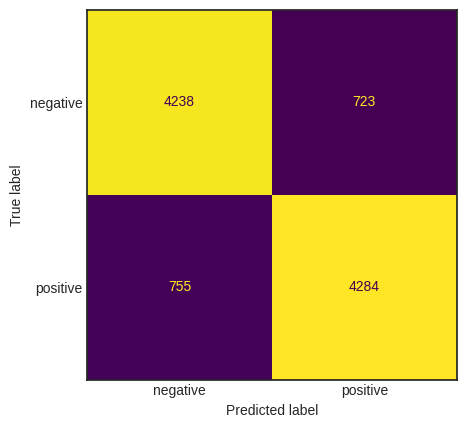

In [7]:
if not grading:
    # Create and train a Naive Bayes classifier
    nb_model = NaiveBayes()
    nb_model.fit(X_train, y_train)
    
    # Predict class labels for validation set
    predictions = nb_model.predict(X_val)
    print(f'Validation Accuracy: {accuracy_score(y_val, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()

### Evaluate the model on your IMDB reviews

Test Accuracy: 0.57


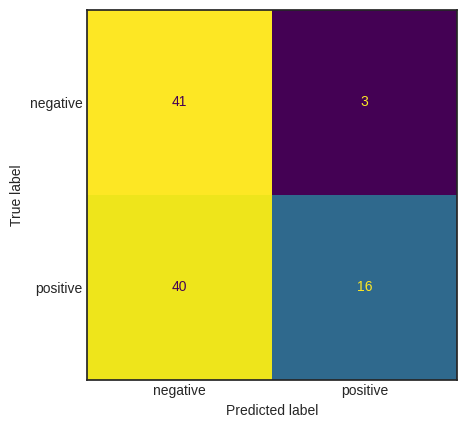

In [8]:
if not grading:
    # Predict class labels for test set
    predictions = nb_model.predict(X_test)
    print(f'Test Accuracy: {accuracy_score(y_test, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()

<div class="alert alert-info" style="color:black"><h2>1.3 Exercise: Artificial Neural Network</h2>

ANN are a discriminative classification algorithm which learn a decision boundary to separate the classes and select appropriate labels based on the input features.

1. In the following cell complete the `build_model()` function. It should take in the following arguments and return a Keras sequential model:
    - `vocab_size` is the input shape, because each word is a feature.
    - `layers_list` is a list of tuples containing the number of neurons and activation function for each layer. Thus the length of the list is also the number of layers (input + hidden). For example: `[(10, 'sigmoid'), (5, 'sigmoid')]` is two layers with sigmoid activation and 10 and 5 units respectively. **Note:** this *does not* include the final output layer.
    - `dropout` is the dropout rate for each intermediate dropout layer after a hidden layer.
    - `n_class` is the number of classes to predict, or the shape of the output layer.
    - `output_activation` is the activation function for the output layer.
    - `optimiser` is the function for calculating the gradient and updating the weights. Should be any valid Keras optimiser e.g. `SGD`.
    - `loss` is the loss function for calculating the error of the model. Should be any valid Keras loss e.g. `categorical_crossentropy`.
    - `name` is just a name to identify the model.

2. The first layer should be an input layer, followed by one hidden layer and one dropout layer for each tuple in `layers_list`. The last layer should be the classification/output layer for `n_class` with `output_activation`.

3. Once all the layers are implemented the function should compile the model with the given optimiser, loss and the accuracy metric (`metrics=["accuracy"]`).

4. Finally, return the compiled model.

<b>MARKS AVAILABLE: 5</b>
<br>
<b>MO1</b>
</div>

In [9]:
def build_model(vocab_size, layers_list, dropout, n_class, output_activation, optimiser, loss, name):
    """Build a simple ANN model

    Arguments:
        vocab_size (int): Size of the vocabulary
        layers_list (list): A list of tuples containing the number of neurons (int) and activation function (str) for each layer
        dropout (int): The dropout rate
        n_class (int): Number of classes
        output_activation (str): Activation function for the output layer
        optimiser (str): Optimiser to use
        loss (str): Loss function to use
        name (str): Name of the model
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
        
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Input
    from tensorflow.keras.optimizers import SGD
    
    # Initializing the sequential model
    model = Sequential(name=name)

    # Adding input layer
    model.add(Input(shape=(vocab_size,)))

    # Adding hidden layers and dropout layers
    for units, activation in layers_list:
        # Adding dense layer
        model.add(Dense(units=units, activation=activation))
        # Adding dropout layer after each hidden layer
        model.add(Dropout(rate=dropout))

    # Adding output layer
    model.add(Dense(units=n_class, activation=output_activation))

    # Compiling the model with optimiser, loss, and accuracy metric
    if optimiser == 'sgd':
        optimiser = SGD(learning_rate=0.01)  
    model.compile(
        optimizer=optimiser,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [10]:
# Test cell (3 marks)

# Create a model using the build_model function
model = build_model(200, [(10, 'sigmoid')], 0.1, 5, 'softmax', 'sgd', 'categorical_crossentropy', 'a_model')

# Test the size of the input shape
assert model.input_shape == (None, 200), 'Input shape should be (None, 200)'

# Test the number of layers
assert len(model.layers) == 3, 'Model should have 3 layers'

# Test the number of neurons in the first layer
assert model.layers[0].units == 10, 'First layer should have 10 neurons'

# Test the activation function of the first layer
assert model.layers[0].activation.__name__ == 'sigmoid', 'First layer should have sigmoid activation'

# Test there is a dropout layer after the first layer
assert isinstance(model.layers[1], layers.Dropout), 'Second layer should be a dropout layer'

# Test the dropout rate
assert model.layers[1].rate == 0.1, 'Dropout rate should be 0.1'

# Test the number of neurons in the second layer
assert model.layers[2].units == 5, 'Second layer should have 5 neurons'

# Test the activation function of the second layer
assert model.layers[2].activation.__name__ == 'softmax', 'Second layer should have softmax activation'

# Test the loss function
assert model.loss == 'categorical_crossentropy', 'Loss should be categorical_crossentropy'

# Test the learning rate
assert model.optimizer.learning_rate == 0.01, 'Learning rate should be 0.01'

# Test the optimiser
assert model.optimizer.name == 'SGD', 'Optimizer should be SGD'

# Test the name
assert model.name == 'a_model', 'Model name should be a_model'

# Test the model type
assert isinstance(model, models.Sequential), 'Model should be a Sequential model'

# Test the number of parameters
assert model.count_params() == 2065, 'Model should have 2065 parameters'

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (2 marks)
# Tests all function parameters with different values


<div class="alert alert-info" style="color:black"><h2>1.4 Exercise: Build a model for classifying the IMDB reviews</h2>

Once you have the `build_model()` function working correctly, select some appropriate parameters and build a model for classifying the IMDB reviews. Adhere to the following constraints:

1. Ensure you use the `vocab_size` defined above (5000).

2. Do not create more than 4 hidden layers.

3. The total number of parameters should be < 300,000.

<b>MARKS AVAILABLE: 5</b>
<br>
<b>MO1</b>
</div>

In [11]:
# YOUR CODE HERE
#raise NotImplementedError()
vocab_size = 5000  
n_class = 1        # (positive/negative class)
layers_list = [
    (56, 'relu'),  # First hidden layer
    (48, 'relu'),   # Second hidden layer
    (32, 'relu'),    # Third hidden layer
    (16, 'relu')    # Fourth hidden layer
]
dropout = 0.2      
output_activation = 'sigmoid'  # Output activation for binary classification
optimiser = 'adam'  
loss = 'binary_crossentropy'  # Loss function for binary classification
name = 'ann_classifier' 

model = build_model(
    vocab_size=vocab_size,
    layers_list=layers_list,
    dropout=dropout,
    n_class=n_class,
    output_activation=output_activation,
    optimiser=optimiser,
    loss=loss,
    name=name
)

model.summary()

Model: "ann_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 56)             │       280,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 48)             │         2,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,905 (1.09 MB)

 Trainable params: 284,905 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Test cell (3 marks)

# Test the size of the input shape
assert model.input_shape == (None, 5000), 'Input shape should be (None, 5000)'

# Test the number of layers
assert len(model.layers) <= 9, 'Model should not have more than 9 layers (4 hidden + 4 dropout and 1 output)'

# Test the number of parameters
assert model.count_params() <= 300000, 'Model should not have more than 300,000 parameters'

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (2 marks)
# Tests output layer and loss function are appropriate for this problem


### Train and evaluate the model

Now train the model for a few epochs and evaluate on the test set. You should see an improvement over the Naive Bayes model. You can compare your models performance to the 'state-of-the-art' listed [here](https://paperswithcode.com/sota/sentiment-analysis-on-imdb).

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7462 - loss: 0.4999 - val_accuracy: 0.8829 - val_loss: 0.2799
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9125 - loss: 0.2351 - val_accuracy: 0.8823 - val_loss: 0.2863
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9439 - loss: 0.1619 - val_accuracy: 0.8779 - val_loss: 0.3242
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Accuracy: 0.8779


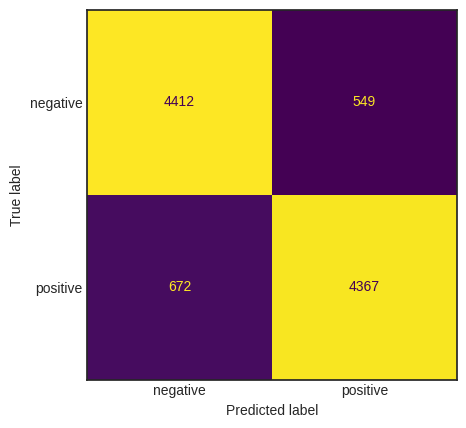

In [13]:
if not grading:
    # Fit the model
    results = model.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=(X_val, y_val))
    
    # Predict class labels for validation set
    predictions = model.predict(X_val)
    predictions = [0 if x < 0.5 else 1 for x in predictions]  # Convert probabilities to binary
    print(f'Validation Accuracy: {accuracy_score(y_val, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()

### Evaluate the model on your IMDB reviews

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy: 0.58


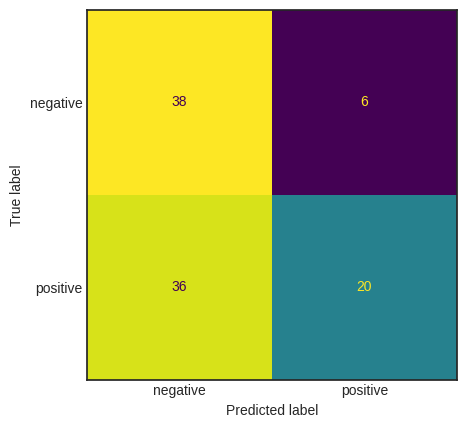

In [14]:
if not grading:
    # Predict class labels for test set
    predictions = model.predict(X_test)
    predictions = [0 if x < 0.5 else 1 for x in predictions]  # Convert probabilities to binary
    print(f'Test Accuracy: {accuracy_score(y_test, predictions)}')
    
    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['negative', 'positive'], colorbar=False)
    plt.show()

<div class="alert alert-info" style="color:black"><h2>1.5 Exercise: Naive Bayes and ANN generalisation</h2>

1. You should have noticed that the Naive Bayes algorithm and ANN performed quite similarly on the full IMDB dataset. However, the ANN should have generalised to your small IMDB reviews data better than Naive Bayes did (assuming you chose appropriate parameters). Why might this be?

2. In general the Naive Bayes algorithm and ANN probably performed much worse on the small IMDB reviews that you gathered and annotated. Why might this be and what could be done to resolve this issue?

</div>

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280